In [1]:
import torch #GPU: NVIDIA Tesla P100
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU found: {torch.cuda.get_device_name(0)}")
    properties = torch.cuda.get_device_properties(device)
    no_cudacores = properties.multi_processor_count
    print(f"{no_cudacores} CUDA cores on GPU")
else:
    decive = torch.device("cpu")
    print("No GPU found! using CPU")

GPU found: Tesla P100-PCIE-16GB
56 CUDA cores on GPU


In [2]:
%%capture
try:#libraries
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import optim as optim
    from torch.optim import Adam
except Exception as e:
    !pip install optim
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import optim as optim
    from torch.optim import Adam

In [3]:
%%capture
try:
    %matplotlib inline
    from nuscenes.nuscenes import NuScenes
except Exception as e:
    !pip install nuscenes-devkit
    %matplotlib inline
    from nuscenes.nuscenes import NuScenes

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from nuscenes.utils.data_classes import LidarPointCloud
#for each file/instance of observation
directory = '/kaggle/input/multislow-poli/CAVALIER_MULTI-SLOW-POLI/sweeps/LIDAR_FUSED'
save = r'/kaggle/working/'
files = sorted(os.listdir(directory))
print(files[0])
pcdpath = os.path.join(directory, files[0])
pcd = LidarPointCloud.from_file(pcdpath)
#print(pcd.points)
#extract feature coordiantes from pcd
pcd4d = torch.tensor(pcd.points[:,:], dtype=torch.float32)
#print(pcd4d)
in_neurons = pcd4d.shape[1]
print(in_neurons)
#moving to gpu here
pcd4d_gpu = pcd4d.to('cuda')
print(pcd4d_gpu)
#extract lidar pcd
def extract_pcd(directory, ifile):
    pcdpath = os.path.join(directory, ifile)
    pcd = LidarPointCloud.from_file(pcdpath)
    pcd4d = torch.tensor(pcd.points[:,:], dtype=torch.float32)
    return pcd4d

MULTI-SLOW-POLI__LIDAR_FUSED__1641334199802608110.pcd.bin
76321
tensor([[-7.7130e+00, -7.6633e+00, -7.5895e+00,  ...,  5.0485e+00,
          5.0245e+00,  5.0009e+00],
        [ 1.5011e+01,  1.5008e+01,  1.4975e+01,  ..., -4.7160e+00,
         -4.7033e+00, -4.6891e+00],
        [ 1.5049e+00,  1.5034e+00,  1.4998e+00,  ..., -2.1288e-01,
         -2.1006e-01, -2.0713e-01],
        [ 1.5332e-01,  1.3721e-01,  1.5820e-01,  ...,  1.8652e-01,
          2.4902e-02,  2.9297e-03]], device='cuda:0')


torch.cuda.FloatTensor


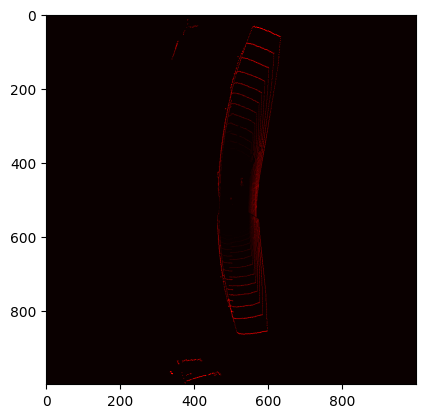

In [5]:
#BEV map creation on GPU for one scan
def convert_scan_bevmap(pcd4d, resolution, bev_map_size):#resolution is also voxwel size
    pcd4d_gpu = pcd4d.to('cuda')
    #extract x,y,z
    x = pcd4d_gpu[0,:]
    y = pcd4d_gpu[1,:]
    z = pcd4d_gpu[2,:]
    #print(x)
    #initialize an empty BEV map
    bev_map = torch.zeros((bev_map_size, bev_map_size), device='cuda')
    #convert point cloud to BEV map
    #Calculate the corresponding pixel for each point in the point cloud
    pixelx = ((x / resolution) + bev_map_size / 2).floor().long() #shifting origins
    pixely = ((y / resolution) + bev_map_size / 2).floor().long()
    #Ignore points that fall outside the BEV map
    mask = (pixelx >= 0) & (pixelx < bev_map_size) & (pixely >= 0) & (pixely < bev_map_size)
    #Update the BEV map (using max pooling here, but can also use average pooling or other methods)
    bev_map[pixelx[mask], pixely[mask]] = torch.max(bev_map[pixelx[mask], pixely[mask]], z[mask])
    return bev_map

bevmap = convert_scan_bevmap(pcd4d, 0.2, 1000)
print(bevmap.type())
# Plot the BEV map
plt.imshow(bevmap.cpu(), cmap='hot')
plt.show()

In [6]:
class pyramidnetwork(nn.Module):
    def __init__(self):
        super(pyramidnetwork, self).__init__()
        ##### encoder
        self.conv1 = nn.Conv2d(16,32,1,1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv1_1 = nn.Conv2d(32,32,3,1,1)
        self.bn1_1 = nn.BatchNorm2d(32)
        self.poolconv1 = nn.Conv2d(32,32,3,1,1)
        self.poolbn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32,64,3,1,1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv2_1 = nn.Conv2d(64,64,3,1,1)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.poolconv2 = nn.Conv2d(64,64,3,1,1)
        self.poolbn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64,128,3,1,1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv3_1 = nn.Conv2d(128,128,3,1,1)
        self.bn3_1 = nn.BatchNorm2d(128)
        self.poolconv3 = nn.Conv2d(128,128,3,1,1)
        self.poolbn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128,256,3,1,1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv4_1 = nn.Conv2d(256,256,3,1,1)
        self.bn4_1 = nn.BatchNorm2d(256)
        self.poolconv4 = nn.Conv2d(256,256,3,1,1)
        self.poolbn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256,512,3,1,1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv5_1 = nn.Conv2d(512,512,3,1,1)
        self.bn5_1 = nn.BatchNorm2d(512)
        self.poolconv5 = nn.Conv2d(512,512,3,1,1)
        self.poolbn5 = nn.BatchNorm2d(512)
        
        self.conv6 = nn.Conv2d(512,1024,3,1,1)
        self.bn6 = nn.BatchNorm2d(1024)
        self.conv6_1 = nn.Conv2d(1024,1024,3,1,1)
        self.bn6_1 = nn.BatchNorm2d(1024)
        self.poolconv6 = nn.Conv2d(1024,1024,3,1,1)
        self.poolbn6 = nn.BatchNorm2d(1024)
        ##### decoder
        self.tranconv6 = nn.ConvTranspose2d(1024,512,3,2)
        self.tranbn6 = nn.BatchNorm2d(512)
        self.upconv6 = nn.ConvTranspose2d(1024,512,3,1,1,dilation=2)
        self.upbn6 = nn.BatchNorm2d(512)
        self.upconv6_1 = nn.Conv2d(512,512,3,1,1,dilation=2)
        self.upbn6_1 = nn.BatchNorm2d(512)
        
        self.tranconv5 = nn.ConvTranspose2d(512,256,2,2)
        self.tranbn5 = nn.BatchNorm2d(256)
        self.upconv5 = nn.ConvTranspose2d(512,256,3,1,1,dilation=3)
        self.upbn5 = nn.BatchNorm2d(256)
        self.upconv5_1 = nn.Conv2d(256,256,3,1,1,dilation=3)
        self.upbn5_1 = nn.BatchNorm2d(256)
        
        self.tranconv4 = nn.ConvTranspose2d(256,128,3,2)
        self.tranbn4 = nn.BatchNorm2d(128)
        self.upconv4 = nn.ConvTranspose2d(256,128,3,1,1,dilation=3)
        self.upbn4 = nn.BatchNorm2d(128)
        self.upconv4_1 = nn.Conv2d(128,128,3,1,1,dilation=3)
        self.upbn4_1 = nn.BatchNorm2d(128)
        
        self.tranconv3 = nn.ConvTranspose2d(128,64,2,2)
        self.tranbn3 = nn.BatchNorm2d(64)
        self.upconv3 = nn.ConvTranspose2d(128,64,3,1,1,dilation=3)
        self.upbn3 = nn.BatchNorm2d(64)
        self.upconv3_1 = nn.Conv2d(64,64,3,1,1,dilation=4)
        self.upbn3_1 = nn.BatchNorm2d(64)
        
        self.tranconv2 = nn.ConvTranspose2d(64,32,2,2)
        self.tranbn2 = nn.BatchNorm2d(32)
        self.upconv2 = nn.ConvTranspose2d(64,32,3,1,1,dilation=3)
        self.upbn2 = nn.BatchNorm2d(32)
        self.upconv2_1 = nn.Conv2d(32,32,3,1,1,dilation=4)
        self.upbn2_1 = nn.BatchNorm2d(32)
        
        self.tranconv1 = nn.ConvTranspose2d(32,16,2,2)
        self.tranbn1 = nn.BatchNorm2d(16)
        self.upconv1 = nn.ConvTranspose2d(32,16,1,1,dilation=4)
        self.upbn1 = nn.BatchNorm2d(16)
        self.upconv1_1 = nn.Conv2d(16,16,3,1,1,dilation=4)
        self.upbn1_1 = nn.BatchNorm2d(16)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
    def forward(self, pastscans,currscan):
        #stack scans
        xbevs = pastscans + [currscan]
        xbevs_stack = torch.stack(xbevs)
        xbevs_stack = xbevs_stack.float()
        xbevs_ten = xbevs_stack.unsqueeze(0)
        print(xbevs_ten.shape)
        #encoding
        x1 = F.leaky_relu(self.bn1(self.conv1(xbevs_ten)),negative_slope=0.01)
        x1 = F.leaky_relu(self.bn1_1(self.conv1_1(x1)),negative_slope=0.01)
        x_1 = self.maxpool(x1)
        x_1 = F.leaky_relu(self.poolbn1(self.poolconv1(x_1)),negative_slope=0.01)
        x1 = self.maxpool(x1)

        x2 = F.leaky_relu(self.bn2(self.conv2(x1)),negative_slope=0.01)
        x2 = F.leaky_relu(self.bn2_1(self.conv2_1(x2)),negative_slope=0.01)
        x_2 = self.maxpool(x2)
        x_2 = F.leaky_relu(self.poolbn2(self.poolconv2(x_2)),negative_slope=0.01)
        x2 = self.maxpool(x2)

        x3 = F.leaky_relu(self.bn3(self.conv3(x2)),negative_slope=0.01)
        x3 = F.leaky_relu(self.bn3_1(self.conv3_1(x3)),negative_slope=0.01)
        x_3 = self.maxpool(x3)
        x_3 = F.leaky_relu(self.poolbn3(self.poolconv3(x_3)),negative_slope=0.01)
        x3 = self.maxpool(x3)
        
        x4 = F.leaky_relu(self.bn4(self.conv4(x3)),negative_slope=0.01)
        x4 = F.leaky_relu(self.bn4_1(self.conv4_1(x4)),negative_slope=0.01)
        x_4 = self.maxpool(x4)
        x_4 = F.leaky_relu(self.poolbn4(self.poolconv4(x_4)),negative_slope=0.01)
        x4 = self.maxpool(x4)

        x5 = F.leaky_relu(self.bn5(self.conv5(x4)),negative_slope=0.01)
        x5 = F.leaky_relu(self.bn5_1(self.conv5_1(x5)),negative_slope=0.01)
        x_5 = self.maxpool(x5)
        x_5 = F.leaky_relu(self.poolbn5(self.poolconv5(x_5)),negative_slope=0.01)
        x5 = self.maxpool(x5)
        
        x6 = F.leaky_relu(self.bn6(self.conv6(x5)),negative_slope=0.01)
        x6 = F.leaky_relu(self.bn6_1(self.conv6_1(x6)),negative_slope=0.01)
        x_6 = self.maxpool(x6)
        x_6 = F.leaky_relu(self.poolbn6(self.poolconv6(x_6)),negative_slope=0.01)
        #decoding
        x6up = F.leaky_relu(self.tranbn6(self.tranconv6(x_6)),negative_slope=0.01)
        x6cat = torch.cat((x6up, x_5), dim=1)
        x6de = F.leaky_relu(self.upbn6(self.upconv6(x6cat)),negative_slope=0.01)
        x6de = F.leaky_relu(self.upbn6_1(self.upconv6_1(x6de)),negative_slope=0.01)
        
        x5up = F.leaky_relu(self.tranbn5(self.tranconv5(x_5)),negative_slope=0.01)
        x5cat = torch.cat((x5up, x_4), dim=1)
        x5de = F.leaky_relu(self.upbn5(self.upconv5(x5cat)),negative_slope=0.01)
        x5de = F.leaky_relu(self.upbn5_1(self.upconv5_1(x5de)),negative_slope=0.01)

        x4up = F.leaky_relu(self.tranbn4(self.tranconv4(x_4)),negative_slope=0.01)
        x4cat = torch.cat((x4up, x_3), dim=1)
        x4de = F.leaky_relu(self.upbn4(self.upconv4(x4cat)),negative_slope=0.01)
        x4de = F.leaky_relu(self.upbn4_1(self.upconv4_1(x4de)),negative_slope=0.01)
        
        x3up = F.leaky_relu(self.tranbn3(self.tranconv3(x_3)),negative_slope=0.01)
        x3cat = torch.cat((x3up, x_2), dim=1)
        x3de = F.leaky_relu(self.upbn3(self.upconv3(x3cat)),negative_slope=0.01)
        x3de = F.leaky_relu(self.upbn3_1(self.upconv3_1(x3de)),negative_slope=0.01)

        x2up = F.leaky_relu(self.tranbn2(self.tranconv2(x_2)),negative_slope=0.01)
        x2cat = torch.cat((x2up, x_1), dim=1)
        x2de = F.leaky_relu(self.upbn2(self.upconv2(x2cat)),negative_slope=0.01)
        x2de = F.leaky_relu(self.upbn2_1(self.upconv2_1(x2de)),negative_slope=0.01)

        x1up = F.leaky_relu(self.tranbn1(self.tranconv1(x_1)),negative_slope=0.01)
        x1cat = torch.cat((x1up, xbevs_ten), dim=1)
        x1de = F.leaky_relu(self.upbn1(self.upconv1(x1cat)),negative_slope=0.01)
        x1de = F.leaky_relu(self.upbn1_1(self.upconv1_1(x1de)),negative_slope=0.01)
        print(x1de.size())
        
        return x1de

In [7]:
torch.manual_seed(44)
PPN = pyramidnetwork()
PPN_gpu = PPN.to('cuda')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15 (current)
torch.Size([1, 16, 1000, 1000])
torch.Size([1, 16, 994, 994])


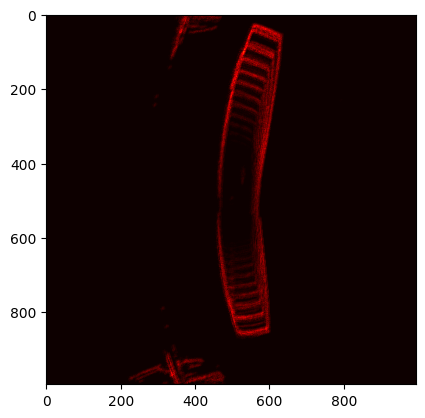

In [8]:
#BEV map creation for a sequence of scans(6 scans=1 sequence)
for i in range(15, 16):#6=len(files)
    #load prev scans(5 scans as prev scans)
    previous_scans = []
    for j in range(i-15, i):
        print(j)
        pcd4d = extract_pcd(directory, files[j])
        bevmap = convert_scan_bevmap(pcd4d, 0.2, 1000)
        # Plot the BEV map
        #plt.imshow(bevmap.cpu(), cmap='hot')
        #plt.show()
        previous_scans.append(bevmap)
    #load current scan
    print(i,r"(current)")
    pcd4d = extract_pcd(directory, files[i])
    current_scan = convert_scan_bevmap(pcd4d, 0.2, 1000)
    # Plot the BEV map
    #plt.imshow(current_scan.cpu(), cmap='hot')
    #plt.show()
    
    #feed into PPN
    ppn_pred_gpu = PPN_gpu(previous_scans,current_scan)
    ppn_pred = ppn_pred_gpu.cpu().detach().numpy()
    ppn_pred_pl = ppn_pred[0, 15, :, :]#batch=1,channel=1
    #plot the image
    plt.imshow(ppn_pred_pl, cmap='hot')
    plt.show()
    

torch.Size([1, 16, 1000, 1000])
torch.Size([1, 16, 994, 994])
15 loss: tensor(0.6375, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([1, 16, 1000, 1000])
torch.Size([1, 16, 994, 994])
16 loss: tensor(0.6209, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([1, 16, 1000, 1000])
torch.Size([1, 16, 994, 994])
17 loss: tensor(0.6070, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([1, 16, 1000, 1000])
torch.Size([1, 16, 994, 994])
18 loss: tensor(0.5950, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([1, 16, 1000, 1000])
torch.Size([1, 16, 994, 994])
19 loss: tensor(0.5827, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([1, 16, 1000, 1000])
torch.Size([1, 16, 994, 994])
20 loss: tensor(0.5710, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([1, 16, 1000, 1000])
torch.Size([1, 16, 994, 994])
21 loss: tensor(0.5609, device='cuda:0', grad_fn=<AddBackward0>)
torch.Size([1, 16, 1000, 1000])
torch.Size([1, 16, 994, 994])
22 loss: tensor(0.5476, device='cuda:0', grad_fn=

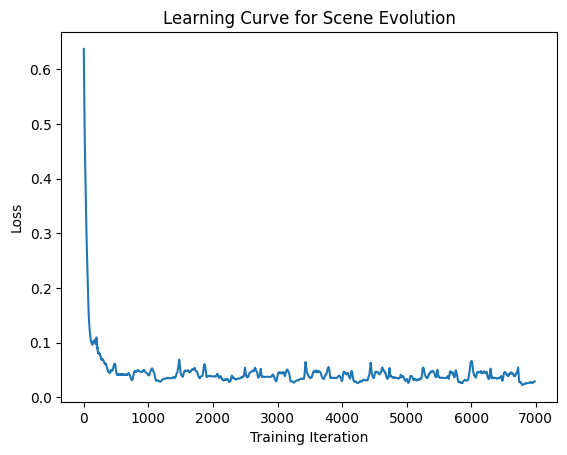

In [9]:
#training
# Hyperparameters
learning_rate = 0.0001
beta = 1  # Smooth L1 loss parameter
lossfun1 = nn.SmoothL1Loss()
lossfun2 = nn.MSELoss()
# Optimizer
optimizer = Adam(PPN_gpu.parameters(), lr=learning_rate)
training_losses = []
for e in range(0,1):
    for i in range(15,7000):
        previous_scans=[]
        for j in range(i-15,i):
            pcd4d = extract_pcd(directory, files[j])
            bevmap = convert_scan_bevmap(pcd4d,0.2,1000)
            previous_scans.append(bevmap)
        pcd4d = extract_pcd(directory, files[i])
        current_scan = convert_scan_bevmap(pcd4d, 0.2,1000)
        #feed into PPN
        ppn_pred_gpu = PPN_gpu(previous_scans,current_scan)
        #corresponding future training scene evolution
        future_scans = []
        for k in range(i+2,i+2+16):
            futpcd = extract_pcd(directory, files[k])
            futbev = convert_scan_bevmap(futpcd, 0.2, 994)
            future_scans.append(futbev)
        bevs_stack = torch.stack(future_scans)
        bevs_stack = bevs_stack.float()
        bevs_ten = bevs_stack.unsqueeze(0)
        #feed into ground turth generator
        loss = lossfun1(ppn_pred_gpu, bevs_ten) + lossfun2(ppn_pred_gpu, bevs_ten)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
        print(i,"loss:",loss)
# learning curve after training
import matplotlib.pyplot as plt
plt.plot(training_losses)
plt.xlabel("Training Iteration")
plt.ylabel("Loss")
plt.title("Learning Curve for Scene Evolution")
plt.show()

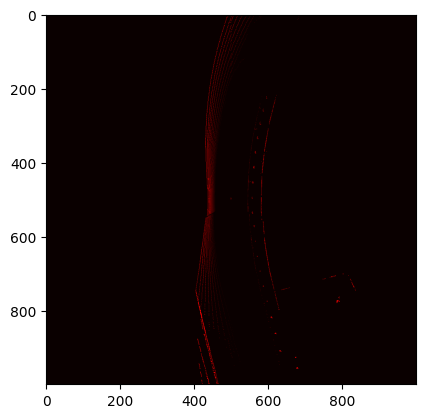

torch.Size([1, 16, 1000, 1000])
torch.Size([1, 16, 994, 994])


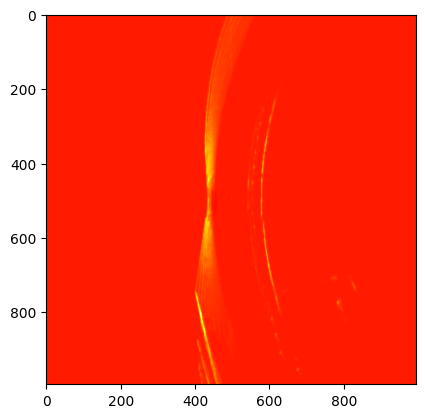

In [10]:
#scene prediction
for i in range(7100,7101):
    previous_scans=[]
    for j in range(i-15,i):
        pcd4d = extract_pcd(directory, files[j])
        bevmap = convert_scan_bevmap(pcd4d,0.2,1000)
        previous_scans.append(bevmap)
    pcd4d = extract_pcd(directory, files[i])
    current_scan = convert_scan_bevmap(pcd4d, 0.2,1000)
    plt.imshow(current_scan.cpu(), cmap='hot')
    plt.show()
    #feed into PPN
    ppn_pred_gpu = PPN_gpu(previous_scans,current_scan)
    future_np = ppn_pred_gpu.cpu().detach().numpy()
    future_pl = future_np[0, 0, :, :]#batch=1,channel=1
    #plot the image
    plt.imshow(future_pl, cmap='hot')
    plt.show()

In [11]:
#validation
torch.manual_seed(44)
future_scans = []
for i in range(7100+2,7100+2+16):
    print(i)
    pcd4d = extract_pcd(directory, files[i])
    bevmap = convert_scan_bevmap(pcd4d,0.2,994)
    future_scans.append(bevmap)
bevs_stack = torch.stack(future_scans)
bevs_stack = bevs_stack.float()
bevs_ten = bevs_stack.unsqueeze(0)
nloss = lossfun1(ppn_pred_gpu, bevs_ten) + lossfun2(ppn_pred_gpu, bevs_ten)
print(nloss)

7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
tensor(0.0272, device='cuda:0', grad_fn=<AddBackward0>)


In [14]:
# computation time on cpu+gpu
import time
import torch
i=15
start_time = time.perf_counter()
# Run some things here
previous_scans=[]
for j in range(i-15,i):
    pcd4d = extract_pcd(directory, files[j])
    bevmap = convert_scan_bevmap(pcd4d,0.2,1000)
    previous_scans.append(bevmap)
pcd4d = extract_pcd(directory, files[i])
current_scan = convert_scan_bevmap(pcd4d, 0.2,1000)
#feed into PPN
ppn_pred_gpu = PPN_gpu(previous_scans,current_scan)

elapsed_time = (time.perf_counter() - start_time)
print(f"Model inference time (might include non-GPU operations): {elapsed_time} seconds")

torch.Size([1, 16, 1000, 1000])
torch.Size([1, 16, 994, 994])
Model inference time (might include non-GPU operations): 0.05692723099991781 seconds


In [15]:
#save trained model's parameters
torch.save(PPN_gpu.state_dict(), "racetrained-PPN.pth")